# Sageでグラフを再現してみよう：データ解析のための統計モデリング入門第１０章
この企画は、雑誌や教科書にでているグラフをSageで再現し、 グラフの意味を理解すると共にSageの使い方をマスターすることを目的としています。

前回に続き、
[データ解析のための統計モデリング入門](http://www.amazon.co.jp/dp/400006973X/)
（以下、久保本と書きます）の第10章の例題をSageを使って再現してみます。

今回の目標は、図10.4です。

![図９．６](images/Fig10.4.png)

数式処理システムSageのノートブックは、計算結果を表示するだけではなく、実際に動かすことができるの大きな特徴です。
この機会にSageを分析に活用してみてはいかがでしょうか。
        
## 前準備       
今回使用するpyjagsがSageの環境では動作しないため、kernelはPython 2を使用します。

最初に必要なライブラリーやパッケージをロードしておきます。sage_util.py, RUtil.pyはloadの代わりにexecを使用して読み込みます。

In [1]:
%%HTML
<link rel="stylesheet" type="text/css" href="css/sage_table_form.css">

In [2]:
# python用のパッケージ
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
# statsmodelsを使ってglmを計算します
import statsmodels.formula.api as smf
import statsmodels.api as sm
from scipy.stats.stats import pearsonr
# jags用パッケージ
import pyjags
%matplotlib inline

# jupyter用のdisplayメソッド
from IPython.display import display, Latex, HTML, Math, JSON
# sageユーティリティ
exec(open('script/sage_util.py').read())
# Rユーティリティ
exec(open('script/RUtil.py').read())
# 乱数のシードをセット
np.random.seed(101)

## 例題のデータ
サポートページから10章のデータをダウンロードします。

### データの素性をみる
いつものようにデータを読み込んだら、ルーティンとしてdescribeと可視化をしましょう。

describeの結果からも分かるとおり、分散（9.93）が大きく、可視化の結果からは山が２つの分布をしています。

In [3]:
d = pd.read_csv('http://hosho.ees.hokudai.ac.jp/~kubo/stat/iwanamibook/fig/hbm/data7a.csv')

In [4]:
# データのカラムを知る。連番idと生存種子数yからデータであることが分かる
d.head()

,id,y
0,1,0
1,2,2
2,3,7
3,4,8
4,5,1


In [5]:
# RのsummaryのようにPandasのDataFrameの情報を出力するには、describeを使用
print "分散=", d.y.var()
d.describe()

分散= 9.92838383838


,id,y
count,100.000000,100.000000
mean,50.500000,4.030000
std,29.011492,3.150934
min,1.000000,0.000000
25%,25.750000,1.000000
50%,50.500000,4.000000
75%,75.250000,7.000000
max,100.000000,8.000000


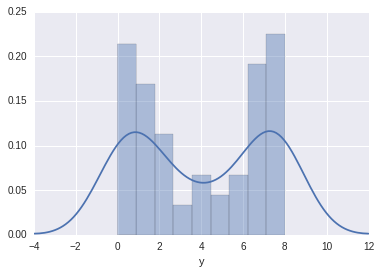

In [6]:
# 生存種子数yのヒストグラムと確率密度分布をプロット
sns.distplot(d.y, bins=9)
plt.show()

### 最尤推定
statmodelsのGLMを使って二項分布の最尤推定をします。

求まった切片（0.015）から、qの最尤推定値は以下の様に求まります。
$$
\hat{q} = \frac{1}{1 + exp(-0.015)} = 0.504
$$

二項分布の分散は、$Nqp = 2.0$ですが、データの分散は9.93で過分散となっています。

In [7]:
# statmodelsのGLMを使って解析する
# N-yのカラムを追加
N = 8
d['NmY'] = N - d.y
fit = smf.glm('y + NmY ~ 1', data=d, family=sm.families.Binomial()).fit()
fit.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
              Results: Generalized linear model
=============================================================
Model:              GLM              AIC:            763.9388
Link Function:      logit            BIC:            175.5773
Dependent Variable: ['y', 'NmY']     Log-Likelihood: -380.97 
Date:               2016-08-21 07:29 LL-Null:        -380.97 
No. Observations:   100              Deviance:       631.49  
Df Model:           0                Pearson chi2:   491.    
Df Residuals:       99               Scale:          1.0000  
Method:             IRLS                                     
--------------------------------------------------------------
             Coef.   Std.Err.    z     P>|z|    [0.025  0.975]
--------------------------------------------------------------
Intercept    0.0150    0.0707  0.2121  0.8320  -0.1236  0.1536
=============================================================

"""

In [8]:
# statmodelsの解析結果を使って生存率qを求める
q = 1/(1+np.exp(-0.015)); q

0.50374992968908194

In [9]:
# 二項分布の分散=Nqp
N*q*(1-q)

1.9998875042186155

### 二項分布との比較
二項分布の最尤推定値$\hat{q} = 0.504$から求まる分布とデータのヒストグラムを重ね合わせてみましょう。

二項分布では観測データを説明できていないことが分かります。

In [10]:
from math import factorial as fac

def binomial(x, y):
    try:
        binom = fac(x) // fac(y) // fac(x - y)
    except ValueError:
        binom = 0
    return binom
# 二項分布を定義
def _p(q, y, N):
    return binomial(N, y)*q**y*(1-q)**(N-y)

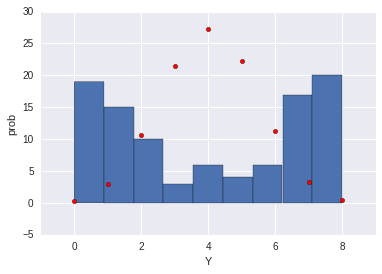

In [11]:
Y = range(9)
q = 0.504
N=8
prob = [_p(q, y, N)*100 for y in Y]
df = pd.DataFrame(zip(Y, prob), columns = ['Y', 'prob'])
ax = d.y.hist(bins=9)
df.plot(kind='scatter', x = 'Y', y='prob', color='red', zorder=2, ax=ax)
plt.show()

## 階層ベイズモデルの推定・予測
二項分布との乖離を生んだのは個体差$r_i$だと仮定して階層ベイズモデルを作成します。

以下に久保本の10.3.1のモデルを示します。jagsではWinBugsのモデルがほぼそのまま使えるのでとても便利です。
- 個体差の標準偏差sは、[0..10000]の一様分布の無情報事前分布から推定
- 個体差$r_i$は、標準偏差sの正規分布からサンプリング
- logistic関数の$q_i = \beta + r+i$から計算し、$q_i$とsから二項分布をサンプリング

In [12]:
N=len(d.y)
code = '''
model {
    for (i in 1:N) {
        Y[i] ~ dbin(q[i], 8)           # 二項分布
        logit(q[i]) <- beta + r[i]  # 生存率
    }
    beta ~ dnorm(0, 1.0E-4)    # 無情報事前分布
    for (i in 1:N) {
        r[i] ~ dnorm(0, tau)         # 階層事前分布
    }
    tau <- 1 / (s * s)                   # tau は分散の逆数
    s ~ dunif(0, 1.0E+4)            # 無情報事前分布
}
'''

事前サンプリングのデフォルト　1000では、$\beta$がばらついたので、adapt=3000としてモデルを作成しました。

In [13]:
model = pyjags.Model(code, data=dict(Y=d.y, N=N), chains=3, adapt=3000)

adapting: iterations 1374 of 9000, elapsed 0:00:01, remaining 0:00:04
adapting: iterations 3180 of 9000, elapsed 0:00:02, remaining 0:00:03
adapting: iterations 5016 of 9000, elapsed 0:00:03, remaining 0:00:02
adapting: iterations 6870 of 9000, elapsed 0:00:04, remaining 0:00:01
adapting: iterations 8730 of 9000, elapsed 0:00:05, remaining 0:00:00
adapting: iterations 9000 of 9000, elapsed 0:00:05, remaining 0:00:00


In [14]:
samples = model.sample(500, vars=['beta', 's'])

sampling: iterations 1320 of 1500, elapsed 0:00:01, remaining 0:00:00
sampling: iterations 1500 of 1500, elapsed 0:00:01, remaining 0:00:00


### サンプリング結果の可視化
計算された$\beta$とsを可視化してみましょう。

In [15]:
# betaの可視化
df_beta = pd.DataFrame(samples['beta'][0], columns=['ch1', 'ch2', 'ch3'])

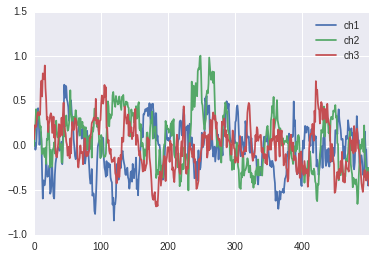

In [16]:
df_beta.plot()
plt.show()

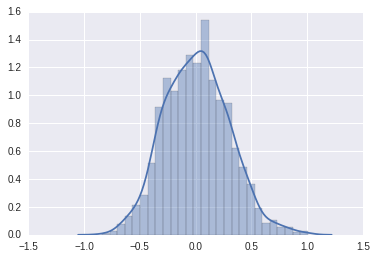

In [17]:
sns.distplot(df_beta.values.flatten())
plt.show()

In [18]:
print np.median(df_beta.values.flatten()), df_beta.values.flatten().mean()

0.00734923506843 0.0115458634885


In [19]:
# betaの可視化
df_s = pd.DataFrame(samples['s'][0], columns=['ch1', 'ch2', 'ch3'])

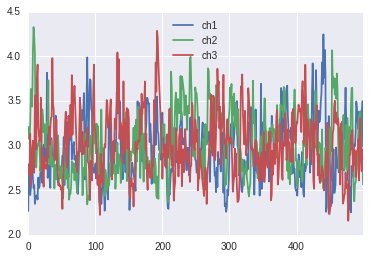

In [20]:
df_s.plot()
plt.show()

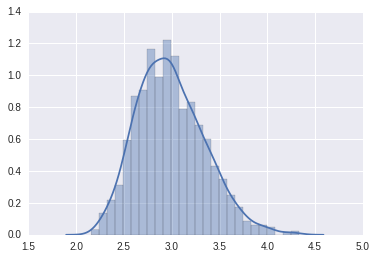

In [21]:
sns.distplot(df_s.values.flatten())
plt.show()

In [22]:
print np.median(df_s.values.flatten()), df_s.values.flatten().mean()

2.9579209966 2.99092478911


## 階層ベイズモデルの事後分布の計算
ここからは、Sageの数値計算を使って計算します。%load_ext sageでSageの関数を利用可能にします。

生存種子数yの確率分布は、二項分布$p(y\,| \,\beta, r)$と正規分布$p(r \,|\, s)$の無限混合分付であり、以下の様にあらわされます。
$$
p(y\,|\,\beta, s) = \int_{-\infty}^{\infty} p(y\,| \,\beta, r)\,p(r \,|\, s)\, dr
$$

In [23]:
# ここからSageの関数を使用します
%load_ext sage

### 生存種子数yの確率分布をプロット
Sageの計算処理を使って、$p(y\,| \,\beta, r)\,p(r \,|\, s)$をプロットしてみます。

In [24]:
# p(y | beta, r)p(r | s)を_rで定義    
def _gauss(r, s):
    return 1/(sqrt(2*pi)*s)*e^(-r^2/(2*s*s))
def _r(y, beta, r, s):
    q = 1/(1+exp(-beta -r))
    return _p(q, y, 8)*_gauss(r, s)

<__main__.Graphics2Html instance at 0x7f61f26075a8>
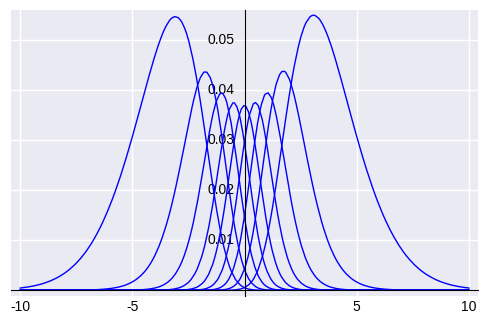

In [25]:
# Yを0..8に変えて分布を計算する
r = var('r')
beta_med = np.median(df_beta.values.flatten())
s_med = np.median(df_s.values.flatten())
plts = Graphics()
for y in (0..8):
    plts += plot(_r(y, beta_med, r, s_med), [r, -10, 10], figsize=5)
# python2カーネルでsageのGraphicsを表示
Graphics2Html(plts)

$p(y\,| \,\beta, r)\,p(r \,|\, s)$の分布からrを-20から20の範囲で数値積分すれば、y毎の生存種子数yの確率分布が計算できることが分かります。

In [26]:
# 上記確率分布をrについて積分する、数値積分の範囲を上記の図から-20から２０とした
def _rInt(y, beta, s):
    (s, e) = numerical_integral(lambda r : _r(y, beta, r, s), -20, 20)
    return s

y毎の生存種子数yの確率分布に100を掛けて、データのヒストグラムと

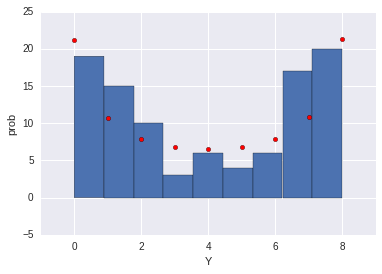

In [27]:
prob = [_rInt(y, beta_med, s_med)*100 for y in range(9)]
df = pd.DataFrame(zip(Y, prob), columns = ['Y', 'prob'])
ax = d.y.hist(bins=9)
df.plot(kind='scatter', x = 'Y', y='prob', color='red', zorder=2, ax=ax)
plt.show()